HomeWork3. Связь бизнес-показателей и DS-метрик

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
   стоимость лечения 15000р, если сделали тест и начали лечить вовремя
   стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
   стоимость теста 1400р
4. Сделать выводы о том, какая модель справилась с задачей лучше других

In [55]:
#Загружаем необохдимые библиотеки и датасет:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
data = pd.read_csv('train_case2.csv', sep = ';', index_col = 'id')
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [24]:
data.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [26]:
#Построим 3 разных модели и сравним их качество: log_regression, gradient_boosting_classifier, random_forest

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))


In [28]:
#-------------------------------------------------------------------------------------------------------------------------------
#Объединяем пайплайны с помощью featureUnion:
#-------------------------------------------------------------------------------------------------------------------------------
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

In [30]:
classifier_lr = Pipeline([
    ('features', feats),
    ('classifier_lr', LogisticRegression(random_state=42)),
])

classifier_gbc = Pipeline([
    ('features', feats),
    ('classifier_gbc', GradientBoostingClassifier(random_state=42)),
])

classifier_rf = Pipeline([
    ('features', feats),
    ('classifier_rf', RandomForestClassifier(random_state=42)),
])

In [32]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='cardio'), 
                                                    data['cardio'], random_state=0)

In [33]:
# запустим кросс-валидацию
cv_scores_lr = cross_val_score(classifier_lr, X_train, y_train, cv=7, scoring='roc_auc')
cv_score_lr = np.mean(cv_scores_lr)
cv_score_std_lr = np.std(cv_scores_lr)
print(f'CV score for Logistic Regression model is {cv_score_lr}+-{cv_score_std_lr}')

cv_scores_gbc = cross_val_score(classifier_gbc, X_train, y_train, cv=7, scoring='roc_auc')
cv_score_gbc = np.mean(cv_scores_gbc)
cv_score_std_gbc = np.std(cv_scores_gbc)
print(f'CV score for XGB model is {cv_score_gbc}+-{cv_score_std_gbc}')

cv_scores_rf = cross_val_score(classifier_rf, X_train, y_train, cv=7, scoring='roc_auc')
cv_score_rf = np.mean(cv_scores_rf)
cv_score_std_rf = np.std(cv_scores_rf)
print(f'CV score for Random Forest model is {cv_score_lr}+-{cv_score_std_rf}')

CV score for Logistic Regression model is 0.7864573689384385+-0.004422021036885763
CV score for XGB model is 0.8023336401314394+-0.003067762759094604
CV score for Random Forest model is 0.7864573689384385+-0.003611330100912611


In [35]:
# обучим пайплайн на всем тренировочном датасете
classifier_lr.fit(X_train, y_train)
y_score_lr = classifier_lr.predict_proba(X_test)[:, 1]

classifier_gbc.fit(X_train, y_train)
y_score_gbc = classifier_gbc.predict_proba(X_test)[:, 1]

classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

Посчитаем необходимые метрики:

In [39]:
b = 1
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test.values, y_score_lr)
precision_gbc, recall_gbc, thresholds_gbc = precision_recall_curve(y_test.values, y_score_gbc)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)

fscore_lr = (1 +b**2) * (precision_lr * recall_lr) / (b**2 * precision_lr + recall_lr)
fscore_gbc = (1 +b**2) * (precision_gbc * recall_gbc) / (b**2 * precision_gbc + recall_gbc)
fscore_rf = (1 +b**2) * (precision_rf * recall_rf) / (b**2 * precision_rf + recall_rf)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
ix_gbc = np.argmax(fscore_gbc)
ix_rf = np.argmax(fscore_rf)

print(f'Best Threshold={thresholds_lr[ix_lr]:.3f}, F-Score={fscore_lr[ix_lr]:.3f}, Precision={precision_lr[ix_lr]:.3f}, Recall={recall_lr[ix_lr]:.3f}')
print(f'Best Threshold={thresholds_gbc[ix_gbc]:.3f}, F-Score={fscore_gbc[ix_gbc]:.3f}, Precision={precision_gbc[ix_gbc]:.3f}, Recall={recall_gbc[ix_gbc]:.3f}')
print(f'Best Threshold={thresholds_rf[ix_rf]:.3f}, F-Score={fscore_rf[ix_rf]:.3f}, Precision={precision_rf[ix_rf]:.3f}, Recall={recall_rf[ix_rf]:.3f}')

Best Threshold=0.387, F-Score=0.730, Precision=0.647, Recall=0.838
Best Threshold=0.395, F-Score=0.740, Precision=0.698, Recall=0.788
Best Threshold=0.350, F-Score=0.719, Precision=0.643, Recall=0.816


Text(0.5,1,'Roc Auc Curve')

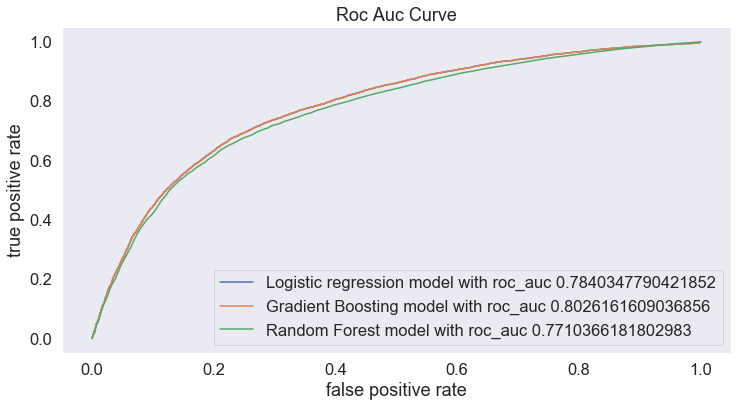

In [54]:
#Посмотрим для каждой модели интегральную метрику roc_auc:
fpr_lr, tpr_lr, tresholds_lr = roc_curve(y_test.values, y_score_lr)
fpr_gbc, tpr_gbc, tresholds_gbc = roc_curve(y_test.values, y_score_gbc)
fpr_rf, tpr_rf, tresholds_rf = roc_curve(y_test.values, y_score_rf)

plt.figure(figsize = (12,6))
plt.plot(fpr_lr, tpr_lr, label = f'Logistic regression model with roc_auc {roc_auc_score(y_test.values, y_score_lr)}')
plt.plot(fpr_lr, tpr_lr, label = f'Gradient Boosting model with roc_auc {roc_auc_score(y_test.values, y_score_gbc)}')
plt.plot(fpr_rf, tpr_rf, label = f'Random Forest model with roc_auc {roc_auc_score(y_test.values, y_score_rf)}')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.grid()
plt.title('Roc Auc Curve')

Найдем лучшую модель по метрикам бизнеса, использовав построенные модели: 

In [76]:
def business_threshold_calibrate(y_test, model,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    
    if model == 'lr':
        y_score = y_score_lr
        thresholds_lr[ix_lr]
        name = 'Логистическая регрессия'
    elif model == 'gbc':
        y_score = y_score_gbc
        thresholds_lr[ix_lr]
        name = 'Градиентный бустинг'
    else:
        y_score = y_score_rf
        thresholds_lr[ix_lr]
        name = 'Случайный лес'
              
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)

    plt.figure(figsize = (12,6))
    plt.title(f'Потери при решении модели {name}')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152712400
Расходы "решение не делать тесты - расходы с МL:" 20887600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1987600


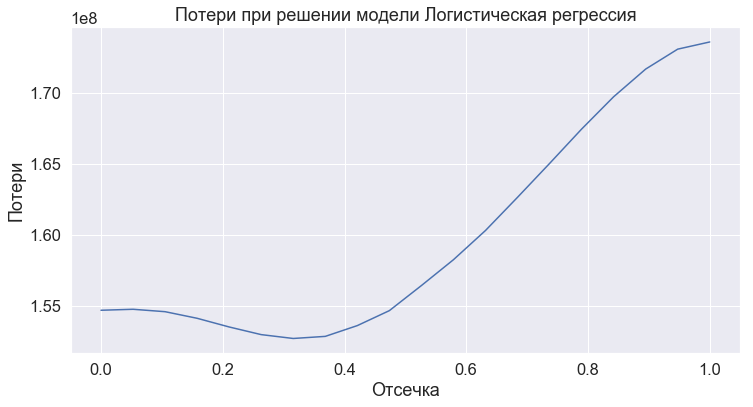

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152333600
Расходы "решение не делать тесты - расходы с МL:" 21266400
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2366400


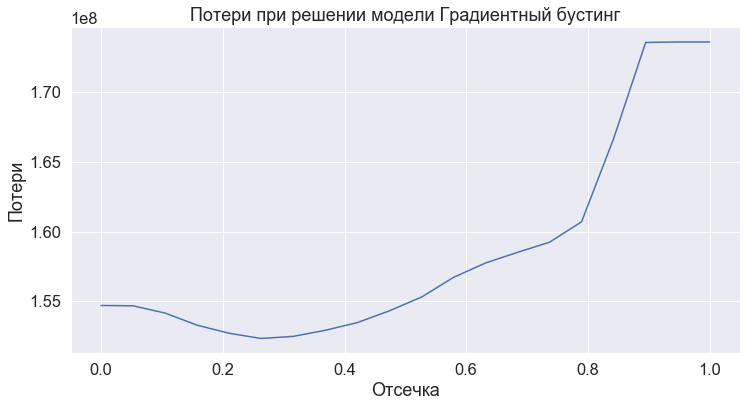

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 153132800
Расходы "решение не делать тесты - расходы с МL:" 20467200
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1567200


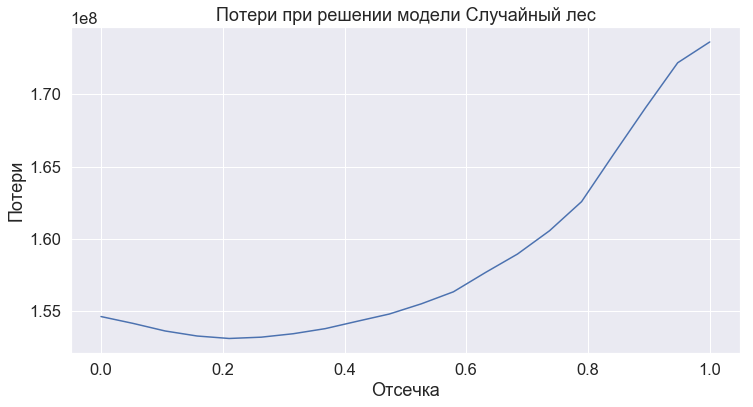

In [77]:
#Смотрим, какое решение с точки зрения бизнеса получается для каждой ml модели:
models = ['lr', 'gbc', 'rf']
for model in models:
    busines_tr = business_threshold_calibrate(y_test, model,
                                              rubl_test=1400, 
                                              rubl_early_treatment=15000, 
                                              rubl_late_treatment=20000)

In [78]:
print('уровень порога по f1 метрике для Логистической регрессии', thresholds_lr[ix_lr])
print('уровень порога по f1 метрике для Градиентного бустинга', thresholds_gbc[ix_gbc])
print('уровень порога по f1 метрике для Случайного леса', thresholds_rf[ix_rf])

уровень порога по f1 метрике для Логистической регрессии 0.38693708911474023
уровень порога по f1 метрике для Градиентного бустинга 0.39494659702686624
уровень порога по f1 метрике для Случайного леса 0.35


In [ ]:
#Видно, что при использовании модели Градиентного бустинга, для бизнеса мы сэкономили бы больше всего денег по сравнению с
#поголовным тестированием. Другие модели оказываются хуже по качеству как в терминах метрик машинного обучения (f1, roc_auc),
#так и в бизнесовых показателях. Экономия в 2 366 400 рублей по сравнению с тестированием всех. Это на 378 800 руб лучше, чем 
#логистическая регрессия и на 799 200 руб лучше, чем случайный лес.